In [2]:
import sys

import pandas 
import numpy

import matplotlib.pyplot
import seaborn

import networkx

from scipy.stats import ranksums

sys.path.append("../scripts")
from utils import parse_interactome, parse_causal_genes

In [3]:
def parse_scores(scores_file, causal_genes):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            # skip causal genes
            if causal_genes.get(gene) == 1:
                continue
            scores[gene] = float(score)

    return scores

In [4]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            scores_left_out[gene] = float(score)
        
    return scores_left_out

In [5]:
def concatenate_scores(scores, scores_left_out):
    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, p_value = ranksums(df_scores['score'].values, df_scores_left_out['score'].values)

    return df_compare, p_value

In [6]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [7]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Set parameters

In [8]:
PHENOTYPE = "MMAF"
MAX_DISTANCE = 3

#### Load the necessary data

In [9]:
interactome, genes = parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

causal_genes = parse_causal_genes(causal_genes_file="/home/kubicaj/calc/input/causalGenes_allPhenotypes.csv",
                                  canonical_genes_file="/home/kubicaj/calc/input/canonicalGenes.tsv",
                                  genes=genes)

In [55]:
scores = parse_scores(f"/home/kubicaj/calc/output/scores_d{MAX_DISTANCE}_alpha01.tsv", causal_genes)

In [56]:
scores_left_out = parse_leave_one_out(f"/home/kubicaj/calc/output/leave_one_out_d{MAX_DISTANCE}_alpha01/left_out_scores.tsv")

#### Analyze leave-one-out results: newCentrality.py

In [17]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

nonCausal_genes_list = [k for k, v in causal_genes.items() if v == 0]
causal_genes_list = [k for k, v in causal_genes.items() if v == 1]

for source_node in nonCausal_genes_list:
    dict_tmp = {}

    for target_node in causal_genes_list:
        try:
            distance = networkx.shortest_path_length(interactome, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between {PHENOTYPE} and non-{PHENOTYPE} gene: {longest_distance}")

Longest distance between MMAF and non-MMAF gene: 10


In [57]:
df_compare, p_value = concatenate_scores(scores, scores_left_out)

(0.0, 0.02)

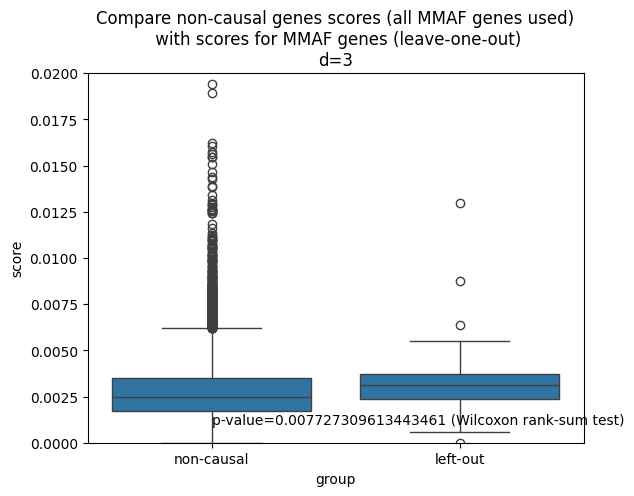

In [58]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\nd={MAX_DISTANCE}")
matplotlib.pyplot.ylim(0, 0.02)

#### Scores analysis newCentrality_v4 more info

In [59]:
scores_sorted = dict(sorted(scores.items(), key=lambda v: v[1], reverse=True))

In [60]:
# get more info about each node (degree, causal genes at distances)
for n, score in scores_sorted.items():
    scores_sorted[n] = [score, 
                        interactome.degree(n), 
                        (n in causal_genes_list),
                        causal_genes_at_distance(dict_distances, n, 1), 
                        causal_genes_at_distance(dict_distances, n, 2),
                        causal_genes_at_distance(dict_distances, n, 3),
                        causal_genes_at_distance(dict_distances, n, 4)]

df = pandas.DataFrame.from_dict(scores_sorted, 
                                orient='index', 
                                columns=['score', 'degree', 'isCausal', 'causal genes at d=1', 'causal genes at d=2', 'causal genes at d=3', 'causal genes at d=4'])

In [9]:
# top 10 high-scoring genes
df.head(10)

NameError: name 'df' is not defined

Text(0.5, 1.0, 'New centrality v4 scores vs. node degree')

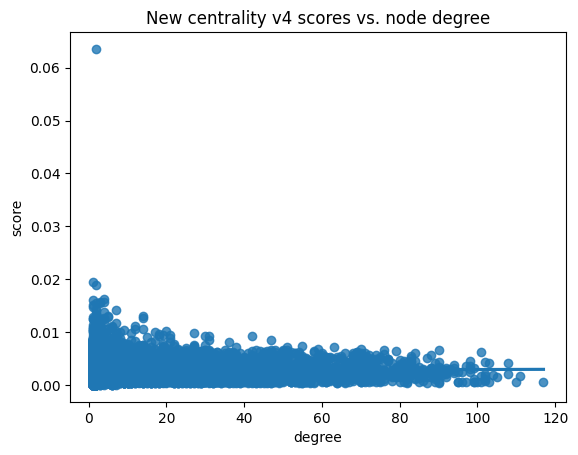

In [43]:
seaborn.regplot(data=df, x="degree", y="score")
matplotlib.pyplot.title("New centrality scores vs. node degree")

#### Analyze new candidates from 13/02/2024

In [93]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [94]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [95]:
# check scores of new candidates
scores_new_candidates = {n: scores.get(n) for n in new_candidates}

In [96]:
scores_new_candidates

{'ENSG00000162994': 0.007260260159322377,
 'ENSG00000025293': 0.001894209422164287,
 'ENSG00000164287': 0.005825827457693127,
 'ENSG00000188732': 0.004685429254192363,
 'ENSG00000128310': 0.0012217470983506415,
 'ENSG00000165115': 0.0052604394294568715,
 'ENSG00000180376': 0.019418580591764947,
 'ENSG00000133101': 0.002870723384191137,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 0.004924446842957367,
 'ENSG00000136449': 0.002955694144769899,
 'ENSG00000078814': 0.003450593054014848,
 'ENSG00000165698': 0.002766139750777555,
 'ENSG00000170469': 0.004178017602682313,
 'ENSG00000132122': 0.0041631074667645256,
 'ENSG00000139908': 0.001960179039975305,
 'ENSG00000120440': 0.00048473097430925833}

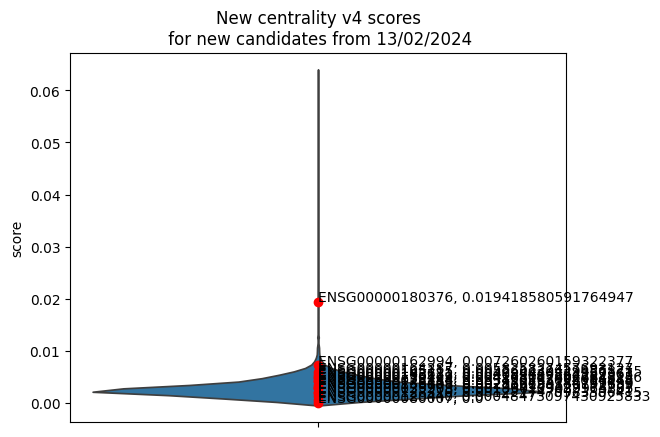

In [97]:
seaborn.violinplot(data=df, y='score')
matplotlib.pyplot.title("New centrality scores\n for new candidates from 13/02/2024")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")